In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
import os 

import config as cfg

In [8]:
train = pd.read_csv(cfg.train)
validation = pd.read_csv(cfg.validation)
df = pd.concat([train, validation])
df.reset_index(inplace=True, drop=True)

assert df.shape[0] == train.shape[0] + validation.shape[0]
train = train.sample(500)
validation = validation.sample(100)

In [9]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [10]:
src = (ImageList.from_df(path=cfg.img_path, df=df)
       .split_by_idx(valid_idx=range(train.shape[0], df.shape[0]))
       .label_from_df(cols='label', label_delim=' '))

In [11]:
data = (src.transform(tfms, size=cfg.image_size)
        .databunch(bs=cfg.batch_size).normalize(imagenet_stats))

In [22]:
assert len(data.valid_ds) == validation.shape[0]
assert len(data.train_ds) == train.shape[0]

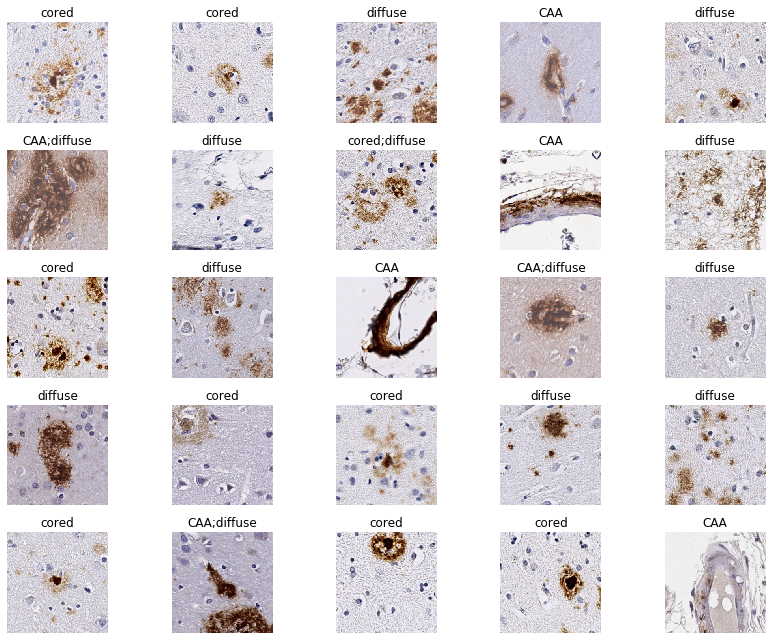

In [12]:
data.show_batch(rows=5, figsize=(12,9))

In [13]:
from fastai.callbacks.tracker import SaveModelCallback, EarlyStoppingCallback

class SaveModelCallbackToDest(SaveModelCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best to specific path."
    def __init__(self,
                 learn:Learner,
                 monitor:str='valid_loss',
                 mode:str='auto',
                 every:str='improvement',
                 name:str='bestmodel',
                 dest:str=None):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name, self.dest = every,name,dest
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
    
    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": self.learn.save(os.path.join(self.dest, f'{self.name}_{epoch}'))
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                print(f'Better model found at epoch {epoch} with {self.monitor} value: {current}.')
                self.best = current
                self.learn.save(os.path.join(self.dest, f'{self.name}'))
                


In [14]:
acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.2)

In [15]:
learn = cnn_learner(data, cfg.model, metrics=[acc_05, f_score], model_dir=cfg.model_dir)

In [16]:
learn.data.classes

['CAA', 'cored', 'diffuse', 'negative']

In [17]:
# learn = learn.to_fp16()
# This didn't speed up training?

In [14]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [ ]:
lr = learn.recorder.min_grad_lr
lr

In [18]:
model_name = f"{cfg.model_name}-stage1-v1"
learn.fit_one_cycle(1, slice(5e-02), callbacks=[SaveModelCallbackToDest(learn,
                                                             every='improvement',
                                                             monitor='valid_loss',
                                                             name='rn50-stage1-v1',
                                                             dest=cfg.model_dir),
                                                         
                                                        ])


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


KeyboardInterrupt: 

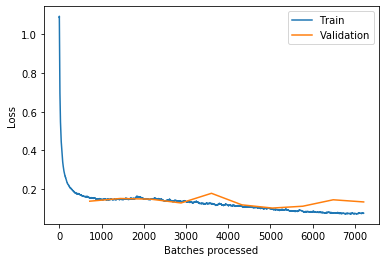

In [36]:
learn.recorder.plot_losses()

In [37]:
# load best model
learn = learn.load(os.path.join(cfg.model_dir, model_name))

In [38]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 6.31E-06


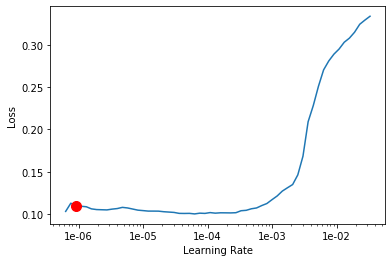

In [39]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
print(lr)
lr2 = learn.recorder.min_grad_lr
print(lr2)

In [40]:
model_name = f"{cfg.model_name}-stage2-v1-best"
learn.fit_one_cycle(20, slice(1e-06, 5e-02/5), callbacks=[SaveModelCallbackToDest(learn,
                                                             every='improvement',
                                                             monitor='valid_loss',
                                                             name=model_name,
                                                             dest=cfg.model_dir),
                                                         
                                                        ])


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.086996,0.115690,0.960023,0.942876,04:51
1,0.079937,0.135546,0.954635,0.934811,04:50
2,0.079389,0.105916,0.965556,0.949100,04:50
3,0.080811,0.125461,0.957590,0.938024,04:49
4,0.075238,0.127362,0.958517,0.942665,04:49
5,0.071028,0.120941,0.962630,0.945622,04:50
6,0.062589,0.107435,0.966251,0.950484,04:50
7,0.057433,0.094752,0.971900,0.956339,04:49
8,0.052285,0.123421,0.958024,0.941684,04:50
9,0.047870,0.130196,0.957822,0.934541,04:50


Better model found at epoch 0 with valid_loss value: 0.11568968743085861.
Better model found at epoch 2 with valid_loss value: 0.10591563582420349.
Better model found at epoch 7 with valid_loss value: 0.09475173056125641.


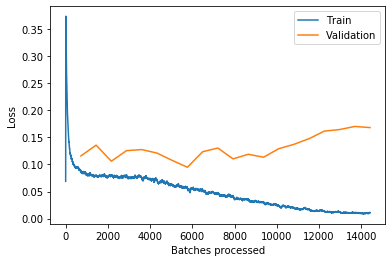

In [41]:
learn.recorder.plot_losses()

In [42]:
learn.save(os.path.join(cfg.model_dir, f"{cfg.model_name}-stage2-v1-epochs{cfg.v2_epochs}"))

In [ ]:
!sudo shutdown -h now